# 0) Setup

In [32]:
# Standard library imports
import ast
import json
import os
import re
import time
import shutil


# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from dotenv import load_dotenv
from scipy import stats
from spacy.matcher import Matcher
from tqdm import tqdm
from typing import Any, List
from sentence_transformers import SentenceTransformer, util

# LangChain imports
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# Local imports
# from utils import extract_answer, extract_facts, make_question
from utils_notebook import extract_answer, format_choices, make_question, SemanticCleaner

cleaner = SemanticCleaner()

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except:
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Load environment variables
load_dotenv()

True

In [33]:
LABELS = ['A','B','C','D']
number = {'A':0,'B':1,'C':2,'D':3}


In [ ]:
# Dataset do arc. (Caso não tenha é necessário instalar e guardar na pasta datasets como csv)
train_df = pd.read_csv("dataset/arc_challenge_train_processed.csv")

In [19]:
# Modelos para extração e tratamento
gpt4 = ChatOpenAI(model='gpt-4o-mini-2024-07-18',temperature=0)
gpt5 = ChatOpenAI(model='gpt-5-nano-2025-08-07',temperature=0)

In [20]:
def call_phi_2(text,temperature=0):
    model = ChatOllama(model="phi", temperature=temperature)
    return model.invoke(text).content

In [81]:
# Modelo avaliador
phi2 = ChatOllama(model="phi", temperature=0) # phi2
phi2_ref = ChatOllama(model='phi',temperature=1.0)

# 1) Extração dos fatos e cálculo do Score

Para realizar essa tarefas iremos:

- 1.1 *Utilizar o Phi2 para responder às perguntas, explicar seu raciocínio e princípios utilizados (fatos)*
- 1.2 *O phi2 irá gerar fatos, os quais extrairemos com o gpt*
- 1.3 *Cada fato receberá um score, que diz o quão o phi2 acha que o fato contribuiu*

In [23]:
question_template = """Instruction: You are an expert science tutor. Your goal is to answer the multiple-choice question below by applying scientific principles.

You must output your response in exactly the following structure:
1. **Principles:** List extensively, but clearly and directly the specific scientific concepts or natural laws applied to answer the question.
2. **Answer:** State only the correct option letter (A, B, C, or D).

----------------
### Question:
{question}
"""

question_prompt = PromptTemplate.from_template(question_template)
question_chain = question_prompt | phi2

In [24]:
def format_choices(choices_str):
    """Converte a string de dicionário do CSV em um formato legível A) ... B) ..."""
    try:
        choices = ast.literal_eval(choices_str)
        formatted = []
        for label, text in zip(choices['label'], choices['text']):
            formatted.append(f"{label}) {text}")
        return "\n".join(formatted)
    except Exception as e:
        return str(choices_str)

In [28]:
def extract_knowledge_components(model_output):
    # Padrão ajustado para ser tolerante a quebras de linha e variações
    pattern = r"1\.\s*Principles:\s*(.*?)\s*2\.\s*Answer:"
    match = re.search(pattern, model_output, re.DOTALL | re.IGNORECASE)
    
    if match:
        return {
            "principles": match.group(1).strip()
        }
    return {"principles": ""}

In [ ]:
BACKUP_FILENAME = "backup_arc_results_partial.csv"

# cleaner = SemanticCleaner()
results = []

max_attempts = 5
temp_base = 0.0
temp_step = 0.1

for i, (index, row) in enumerate(tqdm(train_df.iterrows(), total=len(train_df))):
    
    q_text = row['question']
    options_text = format_choices(row['choices'])
    
    try:
        # LLM Generation (retry if Principles are not returned in the expected format)
        full_question, _ = make_question(row)
        response_text = ""
        extracted = {"principles": ""}
        attempt = 0
        
        while attempt < max_attempts:
            temperature = temp_base + (attempt * temp_step)
            temp_model = ChatOllama(model="phi", temperature=temperature)
            temp_chain = question_prompt | temp_model
            
            response_obj = temp_chain.invoke({"question": full_question})
            response_text = response_obj.content if hasattr(response_obj, 'content') else str(response_obj)
            extracted = extract_knowledge_components(response_text)
            
            if extracted.get("principles"):
                break
            
            attempt += 1
        
        if not extracted.get("principles"):
            raise ValueError("Resposta fora do formato esperado para Principles")
        
        alt_chosen = extract_answer(small_llm_model=gpt5, model_text_output=response_text, valid_labels=LABELS, question=full_question)

        # Extração dos Componentes de Conhecimento
        extracted = extract_knowledge_components(response_text)
        
        #  Salvar na lista
        results.append({
            "id": row['id'],
            "question": q_text,
            "correct_answer": row['answerKey'],
            "alt_chosen": alt_chosen,
            "is_sucess": alt_chosen == row['answerKey'],

            # Dados Brutos (Debug)
            "raw_output": response_text,
            "raw_principles": extracted['principles'],
        })
        
        if (i + 1) % 20 == 0:
            pd.DataFrame(results).to_csv(BACKUP_FILENAME, index=False)

    except Exception as e:
        print(f"Erro ao processar linha {index} (Iteração {i}): {e}")

# Salva o arquivo final definitivo
df_results = pd.DataFrame(results)
print(f"Processamento concluído. {len(df_results)} itens salvos.")

  1%|          | 11/1119 [00:40<1:19:31,  4.31s/it]

Erro ao processar linha 10 (Iteração 10): Resposta fora do formato esperado para Principles


 15%|█▌        | 171/1119 [09:49<1:18:06,  4.94s/it]

Erro ao processar linha 170 (Iteração 170): Resposta fora do formato esperado para Principles


 65%|██████▌   | 728/1119 [48:50<41:13,  6.33s/it]   

Erro ao processar linha 727 (Iteração 727): Resposta fora do formato esperado para Principles


 74%|███████▎  | 823/1119 [55:24<35:54,  7.28s/it]

Erro ao processar linha 822 (Iteração 822): Resposta fora do formato esperado para Principles


 80%|████████  | 900/1119 [1:00:52<25:18,  6.93s/it]

Erro ao processar linha 899 (Iteração 899): Resposta fora do formato esperado para Principles


100%|██████████| 1119/1119 [1:16:23<00:00,  4.10s/it]

Processamento concluído. 1114 itens salvos.


In [130]:
df_results.to_csv("arc_results_final_v2.csv", index=False)

In [43]:
print("Acurácia de treino: ", round(df_results['is_sucess'].mean(), 3) *100, "%")

Acurácia de treino:  76.8 %


In [34]:
df_results['clean_principles'] = df_results['raw_principles'].apply(lambda x: cleaner.clean(x) if isinstance(x, str) else "")

In [38]:
df_results.iloc[0]['raw_principles']

'The generation of heat through friction is governed by the laws of thermodynamics, specifically the conservation of energy and the conversion of mechanical work into thermal energy. When two surfaces rub against each other, kinetic energy is converted into heat due to the frictional forces between them.'

## A partir daqui podemos tratar os fatos científicos recuperados de duas maneiras: 

- 1) Extraindo eles utillizando um modelo de linguagem GPT (OBS: Isso não invalida o experimento, pois estamos apenas extraindo conhecimento já gerado e organizando ele). Isso geraria mais conhecimento semântico ainda e faria com que tarefas multi-hop tivessem que ter realizada:
    
OBS: Para o artigo usamos essa opção. Se escolher por essa opção, deve-se continuar a análise seguindo a seguinte lógica:  utilizar o .csv gpt_extracted_facts.csv ou criar o prório.. Depois atribuir scores e, por fim tentar refinar os fatos

- 2) Uma falha da opção acima é que isso pode introduzir ruído exagerado no dataset. No caso do artigo isso é importante, pois queremos uma grande quantidade de fatos científicos errados. Nesse caso, podemos usar os fatos como um todo..

## 1.2) Gerando Reflexão

In [120]:
reflection_template = """You are an expert AI cognitive reviewer evaluating an AI agent's reasoning.

Analyze this reasoning episode:
- Question: {question}
- Agent's Chosen Answer: {alt_chosen} but this is a {feedback} response.
- Agent's Semantic Memories (Principles used): {raw_principles}

Based on that try to make a new reasoning of how to answer the question:

Task: Identify exactly what was wrong or missing in the Semantic Memories or the reasoning. Provide the correct scientific principle that should have been used. Be briethly and concise.
Restrictions:  Do not choose {alt_chosen}. Focus only on identifying the missing scientific principle and providing a new one.

# Target Question:
{full_question}
"""

#Task: Identify exactly what was wrong or missing in the Semantic Memories or the reasoning. Provide the correct scientific principle that should have been used. Be briethly and concise.


reflection_prompt = PromptTemplate.from_template(reflection_template)

# Usando o 'gpt5' (ou outro modelo forte) que já estava no seu escopo para a reflexão
reflection_chain = reflection_prompt | phi2_ref

In [126]:
i = 0
row = df_results.iloc[i]

train_row = train_df[train_df['id'] == row['id']]
choices = ast.literal_eval(train_row['choices'][0])

correct_txt = choices['text'][number[row['correct_answer']]]
alt_chosen = choices['text'][number[row['alt_chosen']]]


print(row['question'])
print(alt_chosen, " - ", correct_txt)
print(row['raw_principles'], " - ", correct_txt)

George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?
wet palms  -  dry palms
The generation of heat through friction is governed by the laws of thermodynamics, specifically the conservation of energy and the conversion of mechanical work into thermal energy. When two surfaces rub against each other, kinetic energy is converted into heat due to the frictional forces between them.  -  dry palms


In [127]:
row

id                                                  Mercury_SC_415702
question            George wants to warm his hands quickly by rubb...
correct_answer                                                      A
alt_chosen                                                          B
is_sucess                                                       False
raw_output           \n1. Principles: The generation of heat throu...
raw_principles      The generation of heat through friction is gov...
clean_principles    The generation of heat through friction is gov...
Name: 0, dtype: object

In [128]:
make_question(train_df.iloc[i],get_answer=False)[0]

'George wants to warm his hands quickly by rubbing them. Which skin surface will produce the most heat?\n(A) dry palms\n(B) wet palms\n(C) palms covered with oil\n(D) palms covered with lotion'

In [129]:
i = 0
row = df_results.iloc[i]

feedback_str = "CORRECT" if row['is_sucess'] else "INCORRECT"
    
# Invocar a chain de reflexão passando os dados gerados na etapa anterior
reflection_obj = reflection_chain.invoke({
    "full_question": make_question(train_df.iloc[i],get_answer=False)[0],
    "question": row['question'],
    "alt_chosen": alt_chosen,
    "raw_principles": row['raw_principles'],
    "feedback": feedback_str
})

reflection_text = reflection_obj.content if hasattr(reflection_obj, 'content') else str(reflection_obj)

In [125]:
reflection_text

'  The correct scientific principle that should have been used is (C) palms covered in oil. This is because when two surfaces are covered with oil, there is more contact between them due to the slickness of the surface which increases the friction and thus generates more heat compared to dry or wet palms.\n'

## 1.2) Calculando Score

In [ ]:
df_original = pd.read_csv("arc_results_final.csv")
df_facts = pd.read_csv("gpt_extracted_facts.csv")

In [15]:
selected_cols = [c for c in ["id", "question", "correct_answer", "alt_chosen", "is_sucess", "clean_reasoning"] if c in df_original.columns.tolist()]

df_subset = df_original[selected_cols]

merged_df = pd.merge(df_facts, df_subset, on="id", how="left")

merged_df.to_csv("scientific_facts.csv", index=False)

In [16]:
merged_df.head(1)

,id,scientific_fact,question,correct_answer,alt_chosen,is_sucess,clean_reasoning
0,Mercury_SC_415702,Kinetic energy is the energy an object possess...,George wants to warm his hands quickly by rubb...,A,B,False,The friction between two surfaces generates he...


### A) Prompt de Score

In [17]:
score_template = """Task: Evaluate the contribution of the 'Fact' to the agent's 'Reasoning'.
Assign a Score (-1, 0, or 1).

### Input Data:
Question: {question}
Correct Answer: {correct}
Model Choice: {chosen} (Outcome: {outcome_status})
Fact: "{fact}"
Agent's Reasoning: "{reasoning}"

### Scoring Rules:
-1 (Harmful): The Fact led the agent to a failure. 
   (Look for: Did the reasoning cite this fact to justify the wrong answer?)
 0 (Useless/Unused): The Fact was ignored OR it is irrelevant.
   (Look for: Does the reasoning mention this fact? If not, it's 0, even if the fact is true.)
 1 (Useful): The Fact was essential for the success.
   (Look for: Did the reasoning rely on this specific fact to find the correct answer?)

### Output:
Reflection: (1 sentence analyzing the link between Fact and Reasoning)
Score: (Only write -1, 0, or 1)
"""

score_prompt = PromptTemplate(
    template=score_template,
    input_variables=["question", "chosen", "correct", "outcome_status", "fact", "reasoning"]
)

# Chain simples
score_chain = score_prompt | phi2 | StrOutputParser()

In [18]:
def parse_simple_score(response_text):
    try:
        # Tenta achar "Score: X" ou apenas o número no final
        reflection = response_text
        if "Score:" in response_text:
            parts = response_text.split("Score:")
            reflection = parts[0].replace("Reflection:", "").strip()
            score_text = parts[1]
        else:
            score_text = response_text

        # Regex busca -1, 0 ou 1
        matches = re.findall(r'(?<!\w)-?\d+', score_text)
        
        if matches:
            score = int(matches[-1]) # Pega o último número encontrado
            #  limites
            if score < -1: score = -1
            if score > 1: score = 1
        else:
            score = 0 # Default neutro (O fato não foi 'usado')
            
        return reflection, score
    except:
        return "Error parsing", 0

### B) Atribuindo Score aos fatos

In [ ]:
number = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9}

# 1. Inicializa as colunas novas com valor vazio (None) antes de começar
merged_df['quality_reflection'] = None
merged_df['quality_score'] = None

for i, (index, row) in tqdm(enumerate(merged_df.iterrows()), total=len(merged_df)):
    status = "SUCCESS" if row['is_sucess'] else "FAILURE"
    
    try:
        choices_str = train_df[train_df['id'] == row['id']]['choices'].values[0]
        choices = ast.literal_eval(choices_str)['text']
        
        correct_txt = choices[number[row['correct_answer']]]
        chosen_txt = choices[number[row['alt_chosen']]]

        # Invoca o modelo
        response = score_chain.invoke({
            "question": row['question'],
            "chosen": chosen_txt,
            "correct": correct_txt,
            "outcome_status": status,
            "fact": row['scientific_fact'],
            "reasoning": row['clean_reasoning']
        })
        
        ref, sc = parse_simple_score(response)
        
        merged_df.at[index, 'quality_reflection'] = ref
        merged_df.at[index, 'quality_score'] = sc
            
    except Exception as e:
        # print(f"Erro ID {index}: {e}") # Descomente para debug
        merged_df.at[index, 'quality_reflection'] = "Error"
        merged_df.at[index, 'quality_score'] = 0

    # Save parcial a cada 50
    if (i + 1) % 50 == 0:
        merged_df.to_csv("scientific_facts_scored_simple.csv", index=False)

# Save Final
merged_df.to_csv("scientific_facts_scored_simple.csv", index=False)
print("\nConcluído! Arquivo salvo: scientific_facts_scored_simple.csv")

# Exibe resultado
if merged_df['quality_score'].notna().any():
    print(merged_df['quality_score'].value_counts().sort_index())

100%|██████████| 3302/3302 [1:03:30<00:00,  1.15s/it]  


Concluído! Arquivo salvo: scientific_facts_scored_simple.csv
quality_score
-1     780
0      714
1     1808
Name: count, dtype: int64


ANÁLISE DE CORRELAÇÃO: ACERTO vs. SCORE

1. Distribuição Absoluta (Contagem):
quality_score   -1    0     1
is_sucess                    
False          455  212   172
True           325  502  1636

2. Distribuição Percentual (Normalizado por Linha):
quality_score     -1      0      1
is_sucess                         
False          54.23  25.27  20.50
True           13.20  20.38  66.42

3. Média de Score de Qualidade por Resultado:
is_sucess
False   -0.337306
True     0.532278
Name: quality_score, dtype: object


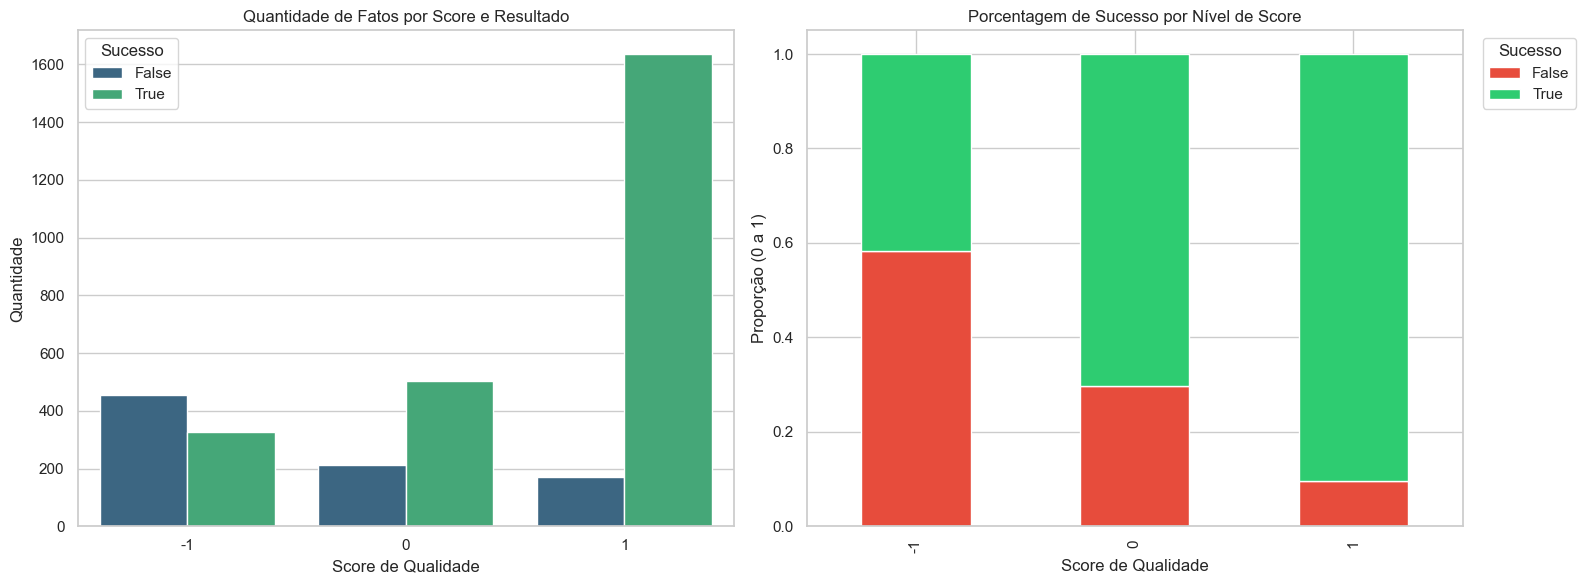

In [96]:
# Set style
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Count Distribution
sns.countplot(
    data=merged_df, 
    x='quality_score', 
    hue='is_sucess', 
    ax=axes[0], 
    palette='viridis'
)
axes[0].set_title('Quantidade de Fatos por Score e Resultado')
axes[0].set_ylabel('Quantidade')
axes[0].set_xlabel('Score de Qualidade')
axes[0].legend(title='Sucesso')

# Plot 2: Normalized Proportion (Stacked Bar)
crosstab_norm = pd.crosstab(merged_df['quality_score'], merged_df['is_sucess'], normalize='index')
crosstab_norm.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[1], 
    color=['#e74c3c', '#2ecc71'] # Red for False, Green for True
)
axes[1].set_title('Porcentagem de Sucesso por Nível de Score')
axes[1].set_ylabel('Proporção (0 a 1)')
axes[1].set_xlabel('Score de Qualidade')
axes[1].legend(title='Sucesso', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
#plt.savefig('score_analysis_real_data.png')

# Print statistics
print("ANÁLISE DE CORRELAÇÃO: ACERTO vs. SCORE")
print("="*40)

# 1. Absolute Count
print("\n1. Distribuição Absoluta (Contagem):")
print(pd.crosstab(merged_df['is_sucess'], merged_df['quality_score']))

# 2. Percentage Distribution
print("\n2. Distribuição Percentual (Normalizado por Linha):")
print((pd.crosstab(merged_df['is_sucess'], merged_df['quality_score'], normalize='index') * 100).round(2))

# 3. Mean Score
print("\n3. Média de Score de Qualidade por Resultado:")
print(merged_df.groupby('is_sucess')['quality_score'].mean())

### B) Tentativa de criar novos fatos a partir do reasoning

In [19]:
scored_df_train = pd.read_csv("scientific_facts_scored_simple.csv")
scored_df_train['quality_reflection'][10]

" The 'Fact' about atmospheric dust blocking sunlight was essential for the agent's reasoning to reach the correct answer. This fact helped the agent understand how an asteroid impact could have caused a significant drop in temperature and led to the extinction of many plants and animals at the end of the Mesozoic era. Therefore, I would assign a score of 1 to this link between Fact and Reasoning.\n"

In [20]:
bad_rows = scored_df_train[scored_df_train['quality_score'] < -0.5]
bad_rows = scored_df_train[scored_df_train['is_sucess'] == False]
bad_rows.head(20)

,id,scientific_fact,question,correct_answer,alt_chosen,is_sucess,clean_reasoning,quality_reflection,quality_score
0,Mercury_SC_415702,Kinetic energy is the energy an object possess...,George wants to warm his hands quickly by rubb...,A,B,False,The friction between two surfaces generates he...,The agent's reasoning is incorrect because it...,-1
1,Mercury_SC_415702,When two surfaces are in contact and move rela...,George wants to warm his hands quickly by rubb...,A,B,False,The friction between two surfaces generates he...,The agent's reasoning is flawed because it ig...,-1
2,Mercury_SC_415702,The roughness or texture of a surface affects ...,George wants to warm his hands quickly by rubb...,A,B,False,The friction between two surfaces generates he...,The agent's reasoning is flawed because it ig...,-1
14,Mercury_SC_401653,Ice as a solid can exert pressure on the land ...,Which land form is the result of the construct...,B,A,False,Glaciers are massive bodies of ice that move u...,The agent' reasoning is flawed because it doe...,-1
15,Mercury_SC_401653,"As glaciers move, they can pick up large amoun...",Which land form is the result of the construct...,B,A,False,Glaciers are massive bodies of ice that move u...,The 'Fact' about plucking and abrasion is rel...,0
16,Mercury_SC_401653,Rocks carried by a glacier can scrape against ...,Which land form is the result of the construct...,B,A,False,Glaciers are massive bodies of ice that move u...,The 'Fact' is relevant to the agent's reasoni...,0
17,MEA_2016_8_14,In both single-celled and multi-cellular organ...,Which statement best compares single-celled an...,C,D,False,To compare single-celled and multi-celled orga...,"The Fact ""In both single-celled and multi-cel...",1
18,MEA_2016_8_14,"In multi-cellular organisms, genetic material ...",Which statement best compares single-celled an...,C,D,False,To compare single-celled and multi-celled orga...,"The statement ""In multi-cellular organisms, g...",0
19,MEA_2016_8_14,"In single-cell organisms, genetic material is ...",Which statement best compares single-celled an...,C,D,False,To compare single-celled and multi-celled orga...,"The Fact ""In single-cell organisms, genetic m...",1
20,MEA_2016_8_14,The cytoplasm in single-cell organisms and the...,Which statement best compares single-celled an...,C,D,False,To compare single-celled and multi-celled orga...,"The Fact ""The cytoplasm in single-cell organi...",1


In [21]:
def call_organizer(fact, temperature=0.1): # Temperatura menor = mais fatual
    prompt = f"""### Instruction:
Extract ONLY one objective scientific sentence from the text below. 
NO introductions, NO explanations, NO conversational filler.

Text: "{fact.strip()}"
Scientific Fact (Write it in only one sentence):"""
    cleaner = SemanticCleaner()

    model = ChatOllama(model="phi", temperature=temperature)
    fact = model.invoke(prompt).content.strip().strip('"').strip("'")
    fact = cleaner.clean(fact)
    return fact

In [23]:
template = """### Instruction:
Complete the reasoning to state a single, short scientific fact.

### Context:
Q: {question}
Correct Answer: {correct_answer}
Critique: {reflection}

### Reasoning:
The Old Fact "{old_fact}" was insufficient because {reflection}.
Therefore, to explain that correct answer is "{correct_answer}" and is not {wrong_answer}, the precise scientific principle is that: ..."""

prompt_fix = PromptTemplate(
    template=template,
    input_variables=["question", "correct_answer", "old_fact", "reflection"]
)

phi2_ref = ChatOllama(model="phi", temperature=0.6) # phi2
chain_fix = prompt_fix | phi2_ref | StrOutputParser()


target_index = [2]
row = bad_rows.iloc[target_index]

train_row = train_df[train_df['id'] == row['id'].iloc[0]].iloc[0]
choices = ast.literal_eval(train_row['choices'])
correct_txt = choices['text'][number[row['correct_answer'].iloc[0]]]


print("\nGerando novo fato com Phi-2...")
new_fact = chain_fix.invoke({
    "question": row['question'],
    "correct_answer": correct_txt,
    "old_fact": row['scientific_fact'],
    "reflection": row['quality_reflection'],
    "wrong_answer": choices['text'][number[row['alt_chosen'].iloc[0]]]
})

new_fact = call_organizer(new_fact,temperature=0.1)

print(f"--- Testando para ID: {row['id']} ---")
print(f"# Questão: {row['question']}\n")
print(f"# Resposta Correta (Alvo): {correct_txt}\n")
print(f'# Resposta do Modelo: {choices["text"][number[row["alt_chosen"].iloc[0]]]}\n')
print(f"# Fato Antigo: {row['scientific_fact']}\n")
print(f"# Crítica: {row['quality_reflection']}\n")
print(f"Novo fato: ", new_fact)


Gerando novo fato com Phi-2...
--- Testando para ID: 2    Mercury_SC_415702
Name: id, dtype: object ---
# Questão: 2    George wants to warm his hands quickly by rubb...
Name: question, dtype: object

# Resposta Correta (Alvo): dry palms

# Resposta do Modelo: wet palms

# Fato Antigo: 2    The roughness or texture of a surface affects ...
Name: scientific_fact, dtype: object

# Crítica: 2     The agent's reasoning is flawed because it ig...
Name: quality_reflection, dtype: object

Novo fato:  The roughness or texture of a surface affects the amount of friction between two surfaces in contact.


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

In [25]:
def is_invalid(question, fact, original_fact, check_size=True, check_content=True, check_similarity=True, min_similarity=0.2, return_reason=False):
    """
    Valida se um fato científico gerado pelo SLM é inválido.
    Inclui verificação de drift semântico via Similaridade de Cosseno.
    """
    if not fact or not isinstance(fact, str):
        return (True, "Fato vazio ou inválido") if return_reason else True

    fact_lower = fact.lower()
    word_count = len(fact.split())
    
    # 1. Validações de Estrutura (Rápidas)
    if check_size:
        size_checks = [
            (word_count > 100, f"Muito longo ({word_count} tokens)"),
            (word_count < 10, f"Muito curto ({word_count} tokens)"),
            ('\n' in fact, "Contém quebras de linha"),
            ('#' in fact or '_' in fact, "Contém caracteres especiais (#/_)"),
            (fact_lower == original_fact.lower(), "Idêntico ao original")
        ]
        for condition, reason in size_checks:
            if condition: return (True, reason) if return_reason else True

    # 2. Validações de Conteúdo (Vazamento de Prompt)
    if check_content:
        forbidden_terms = ['score', 'correct', 'answer', 'instruction:', 'critique:']
        for term in forbidden_terms:
            if term in fact_lower:
                return (True, f"Contém termo proibido: {term}") if return_reason else True

    # 3. Validação de Similaridade (Semântica/Léxica)
    # Garante que o Phi-2 não alucinou um assunto totalmente diferente
    if check_similarity:
        try:
            vectorizer = TfidfVectorizer(stop_words=None) # stop_words podem ser úteis para frases curtas
            tfidf = vectorizer.fit_transform([fact_lower, question.lower()])
            sim = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
            
            if sim < min_similarity:
                reason = f"Baixa similaridade ({sim:.2f}). Possível alucinação."
                return (True, reason) if return_reason else True
        except Exception as e:
            # Falha silenciosa na similaridade (ex: textos sem palavras válidas)
            return (True, "Erro no cálculo de similaridade") if return_reason else True

    return (False, None) if return_reason else False

In [26]:
scored_df_train['origin'] = 'train'

In [27]:
temperature = 0.6
phi2_ref = ChatOllama(model="phi", temperature=temperature) # phi2
chain_fix = prompt_fix | phi2_ref | StrOutputParser()

# Filtrar onde o score foi ruim (-1 ou 0)
# bad_rows = scored_df_train[scored_df_train['quality_score'] < -0.5]

new_rows = []

number = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9}

# Configuração para backup
backup_interval = 50
backup_counter = 0

print("\nGerando novos fatos (train_refined)...")

for idx, (index, row) in enumerate(tqdm(bad_rows.iterrows(), total=len(bad_rows)), start=1):
    try:
        train_row = train_df[train_df['id'] == row['id']].iloc[0]
        choices = ast.literal_eval(train_row['choices'])
        correct_txt = choices['text'][number[row['correct_answer']]]
        q_c = f"{row['question']} {correct_txt}"
        # Gera o novo fato

        new_fact_text = chain_fix.invoke({
            "question": row['question'],
            "correct_answer": correct_txt,
            "old_fact": row['scientific_fact'],
            "reflection": row['quality_reflection'],
            "wrong_answer": choices['text'][number[row['alt_chosen']]]
        })
        clean_new_fact = call_organizer(new_fact_text,temperature=0.1)

        count = 0
        # --- Loop Refatorado ---
        max_attempts = 5
        count = 0

        while is_invalid(question=q_c, fact=clean_new_fact, original_fact=row['scientific_fact'], check_size=True):
            count += 1
            if count > max_attempts:
                print("Tentativa Falhada: Máximo de tentativas atingido.")
                clean_new_fact = "Error generating new fact"
                break
                
            response = chain_fix.invoke({
                "question": row['question'],
                "correct_answer": correct_txt,
                "old_fact": row['scientific_fact'],
                "reflection": row['quality_reflection'],
                "wrong_answer": choices['text'][number[row['alt_chosen']]]
            })

            summarized_fact = call_organizer(response,temperature=0.1)
            summ_count = 0
            summ_max = 3
            while is_invalid(question=q_c, fact=summarized_fact, original_fact=row['scientific_fact'], check_size=True, check_content=True):
                summ_count += 1
                if summ_count > summ_max:
                    break
                summarized_fact = call_organizer(response,temperature=0.3)

            if not is_invalid(question=q_c, fact=summarized_fact, original_fact=row['scientific_fact'], check_size=True, check_content=True):
                clean_new_fact = summarized_fact
                break
            else:
                clean_new_fact = response
                
        new_entry = {
            'id': row['id'],
            'old_fact': row['scientific_fact'],  # Fato antigo
            'scientific_fact': clean_new_fact,     # O fato novo gerado
            'raw_fact': response,          # Fato bruto do modelo
            'question': row['question'],
            'correct_answer': row['correct_answer'],
            # Campos de execução deixamos vazios/nulos pois esse fato nunca foi usado
            'alt_chosen': None,
            'is_sucess': None, 
            'clean_reasoning': None,
            'quality_score': 0,                    # Assumimos 0 pois não testamos esse fato
            'origin': 'train_refined'             
        }
        
        new_rows.append(new_entry)
        
        # Save backup every 50 rows
        if idx % backup_interval == 0:
            backup_counter += 1
            backup_filename = f"backup_train_refined_rows.csv"
            backup_df = pd.DataFrame(new_rows)
            backup_df.to_csv(backup_filename, index=False, encoding='utf-8')
            #print(f"\n✓ Backup salvo: {backup_filename} ({len(new_rows)} registros)")
            
    except Exception as e:
        print(f"Erro no ID {row['id']}: {e}")

# Final save
if new_rows:
    final_filename = f"train_refined_final.csv"
    final_df = pd.DataFrame(new_rows)
    final_df.to_csv(final_filename, index=False, encoding='utf-8')
    print(f"\n✓ Arquivo final salvo: {final_filename} ({len(new_rows)} registros)")


Gerando novos fatos (train_refined)...


  0%|          | 0/839 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [28]:
final_df = pd.read_csv("train_refined_final.csv")

In [29]:
final_df[final_df['scientific_fact'] == 'Error generating new fact']

,id,old_fact,scientific_fact,raw_fact,question,correct_answer,alt_chosen,is_sucess,clean_reasoning,quality_score,origin
122,Mercury_SC_407431,Reducing energy consumption conserves resource...,Error generating new fact,Recycling aluminum reduces the amount of wast...,Aluminum containers can be melted and made int...,C,NaN,NaN,NaN,0,train_refined
182,Mercury_7093030,When sulfuric and nitric acids come into conta...,Error generating new fact,The precise scientific principle behind how a...,How does acid rain most likely affect forests?,D,NaN,NaN,NaN,0,train_refined
255,ACTAAP_2009_7_14,The reaction of carbon with oxygen to form car...,Error generating new fact,"""The reaction of hydrogen with oxygen to form...",Which nongaseous compound can be made from two...,A,NaN,NaN,NaN,0,train_refined
338,MCAS_2004_9_20-v1,Newton's second law of motion states that forc...,Error generating new fact,The correct answer is 16.0 kg x m/s. This is ...,A bowling ball with a mass of 8.0 kg rolls dow...,D,NaN,NaN,NaN,0,train_refined
379,Mercury_402213,The Law of Conservation of Mass states that ma...,Error generating new fact,"The correct answer is ""H_{2}O(l) -> H_{2}O(g)...",Which of these does not illustrate substances ...,A,NaN,NaN,NaN,0,train_refined
380,Mercury_402213,The Law of Definite Proportions states that th...,Error generating new fact,... The Law of Definite Proportions states th...,Which of these does not illustrate substances ...,A,NaN,NaN,NaN,0,train_refined
381,Mercury_402213,Six molecules of carbon dioxide (CO2) and six ...,Error generating new fact,"The chemical equation ""6 CO2 + 6 H2O -> C6H1...",Which of these does not illustrate substances ...,A,NaN,NaN,NaN,0,train_refined
393,Mercury_182613,Independent assortment states that different t...,Error generating new fact,The scientific principle being referred to he...,Fraternal twins may or may not share similar c...,A,NaN,NaN,NaN,0,train_refined
395,Mercury_182613,Fraternal twins come from two separate fertili...,Error generating new fact,The process by which different versions of a ...,Fraternal twins may or may not share similar c...,A,NaN,NaN,NaN,0,train_refined
427,AKDE&ED_2008_8_16,The dominant allele (E) determines attached ea...,Error generating new fact,The agent's reasoning is flawed because it re...,Genes are unable to determine a person's,B,NaN,NaN,NaN,0,train_refined


In [30]:
# # Calculate the length of each scientific fact
# final_df['fact_length'] = final_df['scientific_fact'].astype(str).apply(len)


# df_sorted = final_df.sort_values(by=['id', 'fact_length'], ascending=[True, False])

# # Drop duplicates by id, keeping the first (longest)
# df_unique = df_sorted.drop_duplicates(subset='id', keep='first')

# # Remove the temporary 'fact_length' column if desired, or keep it. I'll remove it to match original structure.
# df_result = df_unique.drop(columns=['fact_length'])

# # Check the results
# print(f"Original row count: {len(final_df)}")
# print(f"Unique id count: {len(df_result)}")

In [31]:
final_df.drop_duplicates(subset=['scientific_fact'], keep=False, inplace=True)

In [32]:
# if new_rows:
    
    # Concatena o original com os novos
df_final = pd.concat([scored_df_train, final_df], ignore_index=True)

# Salva
output_filename = "scientific_facts_expanded.csv"
df_final.to_csv(output_filename, index=False)
    
# else:
#     print("Nenhum fato novo foi gerado.")

Total de fatos comparados: 2901

=== ANÁLISE DE TAMANHO (Palavras) ===
Média de Palavras (Original): 15.90
Média de Palavras (Novo):     26.03
Aumento Médio:                10.14 palavras


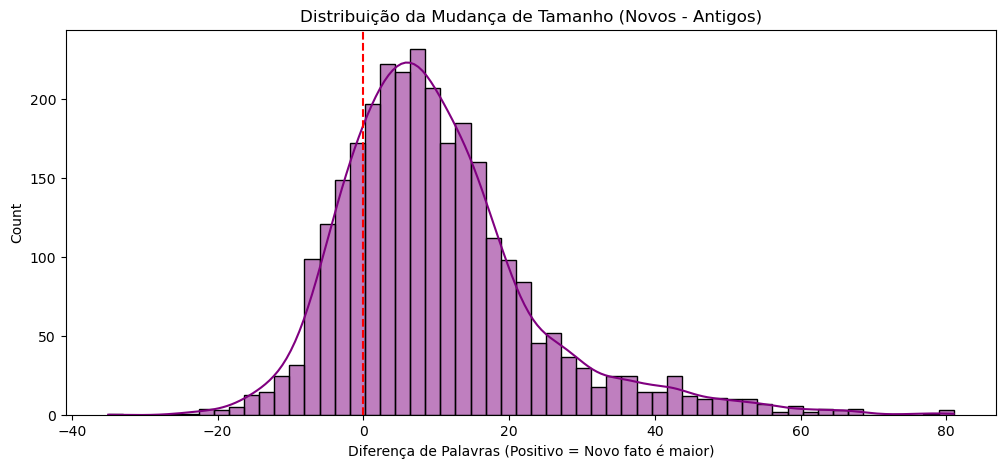


=== ANÁLISE SEMÂNTICA (Carregando Modelo...) ===


Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Similaridade Média: 0.5260
Similaridade Mínima: -0.0388 (Mudança Drástica)
Similaridade Máxima: 0.9984 (Quase idêntico)

Distribuição do Tipo de Mudança:
change_type
Correção Factual (Significado Mudou)    81.868321
Expansão/Clarificação                   16.683902
Reescrita Leve (Estilo)                  1.447777
Name: proportion, dtype: float64


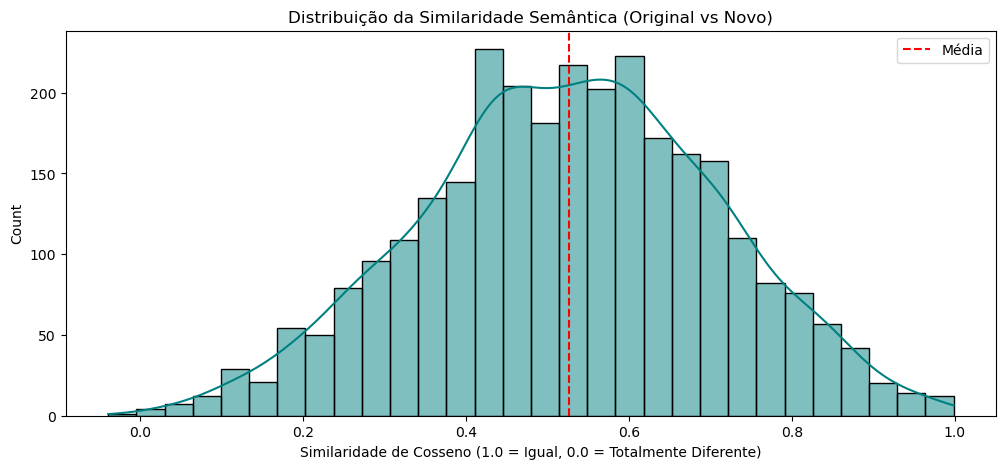


=== EXEMPLOS EXTREMOS ===
Maior Mudança (Menor Similaridade):
Old: The law of conservation of mass states that matter cannot be created or destroyed, only transformed from one form to another.
New: The hydrologist should compare her current data with previous data from the same location and time frame to ensure consistency in her findings. This will help determine if the changes in pH levels are a result of environmental factors or if they have indeed been steadily dropping over time. By retesting the original samples, she can verify the accuracy of her initial observations and confirm that the pH level has been consistently decreasing.
Score: -0.0388

Reescrita Sutil (Maior Similaridade):
Old: The law of conservation of energy states that energy cannot be created or destroyed, only transferred or transformed from one form to another.
New: The law of conservation of energy states that energy can not be created or destroyed, only transferred or transformed from one form to another.
Sco

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 1. Carregar o Dataset Expandido
# Certifique-se de usar o nome do arquivo salvo no passo anterior
df = pd.read_csv("scientific_facts_expanded.csv")

# 2. Preparar os Pares (Original vs Refinado)
# O dataset está empilhado (linhas novas no final). Vamos fazer um merge pelo ID.
df_original = df[df['origin'] == 'train'][['id', 'scientific_fact']].rename(columns={'scientific_fact': 'fact_old'})
df_refined = df[df['origin'] == 'train_refined'][['id', 'scientific_fact']].rename(columns={'scientific_fact': 'fact_new'})

# Merge (Inner Join) para pegar apenas os que foram reescritos
df_comparison = pd.merge(df_original, df_refined, on='id', how='inner')

print(f"Total de fatos comparados: {len(df_comparison)}")

# ---------------------------------------------------------
# ANÁLISE 1: Diferença de Tamanho (Verbosidade)
# ---------------------------------------------------------
df_comparison['len_old'] = df_comparison['fact_old'].apply(lambda x: len(str(x).split()))
df_comparison['len_new'] = df_comparison['fact_new'].apply(lambda x: len(str(x).split()))
df_comparison['len_diff'] = df_comparison['len_new'] - df_comparison['len_old']

# Estatísticas
print("\n=== ANÁLISE DE TAMANHO (Palavras) ===")
print(f"Média de Palavras (Original): {df_comparison['len_old'].mean():.2f}")
print(f"Média de Palavras (Novo):     {df_comparison['len_new'].mean():.2f}")
print(f"Aumento Médio:                {df_comparison['len_diff'].mean():.2f} palavras")

# Gráfico de Tamanho
plt.figure(figsize=(12, 5))
sns.histplot(df_comparison['len_diff'], kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribuição da Mudança de Tamanho (Novos - Antigos)')
plt.xlabel('Diferença de Palavras (Positivo = Novo fato é maior)')
plt.show()

# ---------------------------------------------------------
# ANÁLISE 2: Diferença Semântica (Embedding Similarity)
# ---------------------------------------------------------
print("\n=== ANÁLISE SEMÂNTICA (Carregando Modelo...) ===")
# Modelo leve e eficiente para similaridade
model = SentenceTransformer('all-MiniLM-L6-v2')

# Gerar Embeddings
embeddings_old = model.encode(df_comparison['fact_old'].tolist(), convert_to_tensor=True, show_progress_bar=True)
embeddings_new = model.encode(df_comparison['fact_new'].tolist(), convert_to_tensor=True, show_progress_bar=True)

# Calcular Similaridade de Cosseno (Pares)
# util.cos_sim retorna uma matriz, pegamos a diagonal para comparar par-a-par
cosine_scores = util.pairwise_cos_sim(embeddings_old, embeddings_new)
df_comparison['similarity'] = cosine_scores.cpu().numpy()

# Estatísticas
print(f"Similaridade Média: {df_comparison['similarity'].mean():.4f}")
print(f"Similaridade Mínima: {df_comparison['similarity'].min():.4f} (Mudança Drástica)")
print(f"Similaridade Máxima: {df_comparison['similarity'].max():.4f} (Quase idêntico)")

# Classificação da Mudança
def classify_change(sim):
    if sim > 0.9: return "Reescrita Leve (Estilo)"
    if sim > 0.7: return "Expansão/Clarificação"
    return "Correção Factual (Significado Mudou)"

df_comparison['change_type'] = df_comparison['similarity'].apply(classify_change)
print("\nDistribuição do Tipo de Mudança:")
print(df_comparison['change_type'].value_counts(normalize=True) * 100)

# Gráfico de Similaridade
plt.figure(figsize=(12, 5))
sns.histplot(df_comparison['similarity'], kde=True, color='teal', bins=30)
plt.title('Distribuição da Similaridade Semântica (Original vs Novo)')
plt.xlabel('Similaridade de Cosseno (1.0 = Igual, 0.0 = Totalmente Diferente)')
plt.axvline(df_comparison['similarity'].mean(), color='red', linestyle='--', label='Média')
plt.legend()
plt.show()

# ---------------------------------------------------------
# EXIBIR EXEMPLOS
# ---------------------------------------------------------
print("\n=== EXEMPLOS EXTREMOS ===")
print("Maior Mudança (Menor Similaridade):")
min_row = df_comparison.loc[df_comparison['similarity'].idxmin()]
print(f"Old: {min_row['fact_old']}")
print(f"New: {min_row['fact_new']}")
print(f"Score: {min_row['similarity']:.4f}")

print("\nReescrita Sutil (Maior Similaridade):")
max_row = df_comparison.loc[df_comparison['similarity'].idxmax()]
print(f"Old: {max_row['fact_old']}")
print(f"New: {max_row['fact_new']}")
print(f"Score: {max_row['similarity']:.4f}")

In [44]:
print("\n=== APLICANDO FILTRO DE SIMILARIDADE ===")

THRESHOLD = 0.90


ids_to_drop = df_comparison[df_comparison['similarity'] >= THRESHOLD]['id'].values

print(f"IDs identificados para remoção (Similaridade >= {THRESHOLD}): {len(ids_to_drop)}")

condition_to_drop = (df['origin'] == 'train_refined') & (df['id'].isin(ids_to_drop))

df_cleaned = df[~condition_to_drop]


initial_rows = len(df)
final_rows = len(df_cleaned)
removed_rows = initial_rows - final_rows

print(f"\nLinhas iniciais: {initial_rows}")
print(f"Linhas removidas: {removed_rows}")
print(f"Linhas finais:    {final_rows}")

# Salvar o novo dataset limpo
output_filename = "scientific_facts_expanded.csv"
df_cleaned.to_csv(output_filename, index=False)
print(f"\nDataset limpo salvo como: '{output_filename}'")


=== APLICANDO FILTRO DE SIMILARIDADE ===
IDs identificados para remoção (Similaridade >= 0.9): 42

Linhas iniciais: 4100
Linhas removidas: 107
Linhas finais:    3993

Dataset limpo salvo como: 'scientific_facts_expanded.csv'


In [37]:
strange_row = df_final[df_final['scientific_fact']=='The hydrologist should compare her current data with previous data from the same location and time frame to ensure consistency in her findings. This will help determine if the changes in pH levels are a result of environmental factors or if they have indeed been steadily dropping over time. By retesting the original samples, she can verify the accuracy of her initial observations and confirm that the pH level has been consistently decreasing.']